**Task**

Use the archive [iris.csv](data/iris.csv). The goal is to classify into one of the three categories based on four such properties.

Split the iris dataset into a training set and a test set (notice the ordering in the CSV file). After that, apply the non-weighted version of the k-NN algorithm considering only the first two features, for k=3. The program should run k-NN and print the accuracy on the test set. Also, it should create and display a 2D graph showing the training data, where different classes are colored differently. On the same graph, display the regions classified into each of the classes.

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [ ]:
# Data preprocessing
file_path = 'iris.csv'
data = pd.read_csv(file_path, usecols=['sepal_length', 'sepal_width', 'species'])

X = data.drop('species', axis=1)        # features
y = data['species']                     # target

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Equal number of all 3 types in both data sets (stratify = y)
train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, test_size=0.08, random_state=42, stratify=y_encoded)

print(train_X.head())
print("-------------------------------")

# We are checking if the targets are equally distributedd
unique, counts = np.unique(train_y, return_counts=True)
print('Train species: \n', dict(zip(unique, counts)))
unique, counts = np.unique(test_y, return_counts=True)
print('Test species: \n', dict(zip(unique, counts)))

     sepal_length  sepal_width
1             4.9          3.0
120           6.9          3.2
9             4.9          3.1
52            6.9          3.1
118           7.7          2.6
-------------------------------
Train species: 
 {0: 46, 1: 46, 2: 46}
Test species: 
 {0: 4, 1: 4, 2: 4}


Preciznost: 0.00


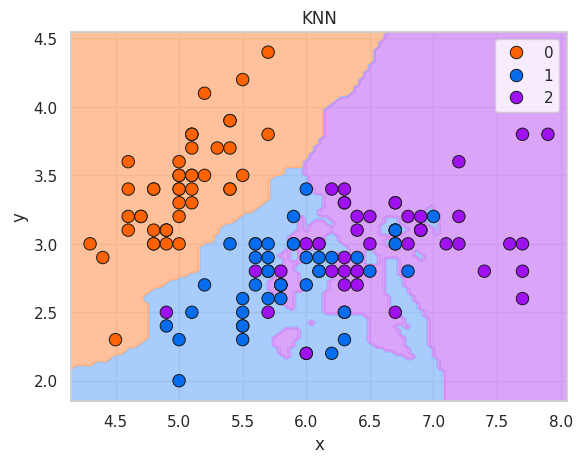

In [ ]:
class KNN:
    def __init__(self, nb_features, nb_classes, data, k, weighted=False):
        self.nb_features = nb_features
        self.nb_classes = nb_classes
        self.k = k
        self.weighted = weighted
        self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
        self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)

    def predict(self, query_data):
        nb_queries = query_data['x'].shape[0]
        predictions = []

        for i in range(nb_queries):
            # pandas DataFrame -> tensor
            query_point = tf.convert_to_tensor(query_data['x'].iloc[i].values, dtype=tf.float32)

            # Euclidean distance from the training point to all other points
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_point)), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)

            classes = tf.gather(self.Y, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / (dists + 1e-6)                   # + small number to avoid division by zero
            else:
                w = tf.fill([self.k], 1.0 / self.k)

            w_col = tf.reshape(w, (self.k, 1))
            classes_one_hot = tf.one_hot(classes, self.nb_classes)
            scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)
            hyp = tf.argmax(scores)

            # append to predictions
            predictions.append(hyp.numpy())

        return predictions

def plot_result(model, X, y, cmap_light = None, cmap_bold = None):
    if cmap_light is None:
        cmap_light = ListedColormap(['#ffb282', '#93c0fa', '#d18ff7'])
    if cmap_bold is None:
        cmap_bold = ListedColormap(['#ff6200', '#076ced', '#a011f2'])

    # Plotting boundaries
    x_min = X[:, 0].min() - 0.15
    x_max = X[:, 0].max() + 0.15
    y_min = X[:, 1].min() - 0.15
    y_max = X[:, 1].max() + 0.15

    # Decision boundaries -> generated x and y coordinates for the mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # We are interested in the model prediction, not accuracy -> we don't have the 'y' value
    data = {'x': pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])}
    grid_predictions = model.predict(data)

    Z = np.array(grid_predictions).reshape(xx.shape)

    sns.set(style="whitegrid")
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)

    # Points from the provided dataset
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold.colors, edgecolor='k', s=80)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('KNN')
    plt.show()

train_data = {'x': train_X, 'y': train_y}
test_data = {'x': test_X, 'y': test_y}

knn = KNN(nb_features = 2, nb_classes = 3, train_data = train_data, k = 3)
plot_result(knn, train_X.to_numpy(), train_y)           